# Seminar 01: Naive Bayes from scratch

Today we will write Naive Bayes classifier supporting different feature probabilities

## Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

First to load dataset we're going to use [`sklearn`](https://scikit-learn.org/stable/) package which we will extensively use during the whole course.

`sklearn` implement most of classical and frequently used algorithms in Machine Learning. Also it provides [User Guide](https://scikit-learn.org/stable/user_guide.html) describing principles of every bunch of algorithms implemented.

As an entry point to main `sklearn`'s concepts we recommend [getting started tutorial](https://scikit-learn.org/stable/getting_started.html) (check it out yourself). [Further tutorials](https://scikit-learn.org/stable/tutorial/index.html) can also be handy to develop your skills.

First functionality we use is cosy loading of [common datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). All we need to do is just one function call.

Object generated by [`load_iris`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) is described as:

> Dictionary-like object, the interesting attributes are:
>
> ‘data’, the data to learn,
>
>‘target’, the classification labels,
>
>‘target_names’, the meaning of the labels,
>
>‘feature_names’, the meaning of the features,
>
>‘DESCR’, the full description of the dataset,
>
>‘filename’, the physical location of iris csv dataset (added in version 0.20)

Let's see what we have

In [2]:
dataset = datasets.load_iris()

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

If you aren't familiar with Iris dataset - take a minute to read description above =) (as always [more info about it in Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set))

__TL;DR__ 150 objects equally distributed over 3 classes each described with 4 continuous features

Just pretty table to look at:

In [3]:
# for now you don't need to understand what happens in this code - just look at the table
ext_target = dataset.target[:, None]
pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'],
)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


Now give distinct names to the data we will use

In [4]:
features = dataset.data
target = dataset.target

features.shape, target.shape

((150, 4), (150,))

__Please, remember!!!__

Anywhere in our course we have an agreement to shape design matrix (named `features` in code above) as 

`(#number_of_items, #number_of_features)`

## Visualize dataset

Our dataset has 4 dimensions however humans are more common to 3 or even 2 dimensional data, so let's plot first 3 features colored with labels values

In [5]:
from mpl_toolkits.mplot3d import Axes3D

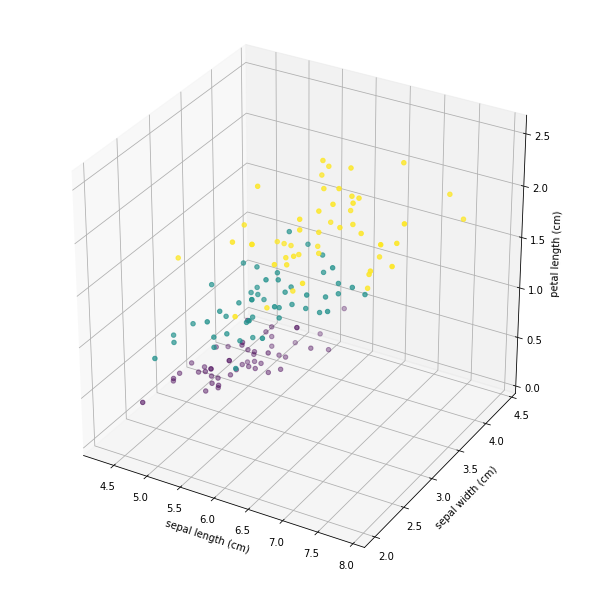

In [6]:
fig = plt.figure(figsize=(8, 8))

ax = Axes3D(fig)

ax.scatter(features[:, 0], features[:, 1], features[:, 3], c=target, marker='o')
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])
ax.set_zlabel(dataset.feature_names[2])

plt.show()

Then have a look on feature distributions

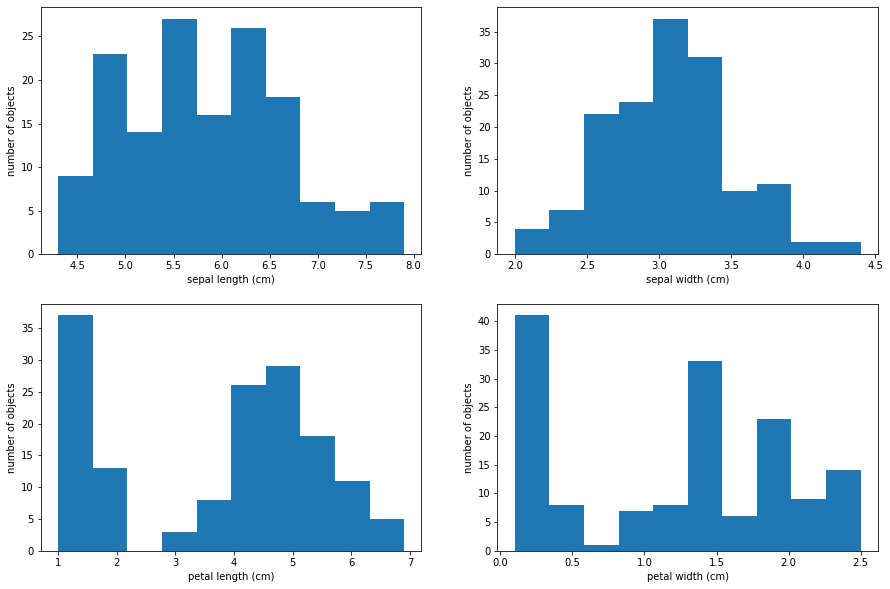

In [7]:
# remember this way to make subplots! It could be useful for you later in your work

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, axis in enumerate(axes.flat):
    axis.hist(features[:, i])
    axis.set_xlabel(dataset.feature_names[i])
    axis.set_ylabel('number of objects')

Note that every plot above have own scale

## Classifier implementation

Since we aiming to implement Naive Bayes algorithm first we need some prior distribution defined.

The most common distribution is (of course) Gaussian and it's params are mean and standard deviation. Let's implement class taking list of feature values, estimating distribution params and able to give probability density of any given feature value.

In [8]:
class GaussianDistribution:
    def __init__(self, feature):
        '''
        Args:
            feature: column of design matrix, represents all available values
                of feature to model
        '''
        self.mean = feature.mean()
        self.std = feature.std()

    def log_proba(self, value):
        '''Logarithm of probability density at value'''
        return # <YOUR CODE HERE>
    
    def proba(self, value):
        return # <YOUR CODE HERE>

In [9]:
assert np.allclose(
    GaussianDistribution(features[:, 2]).proba(features[:5, 2]),
    np.array([0.19195815, 0.19195815, 0.18463525, 0.19924939, 0.19195815])
), 'Something wrong with the GaussianDistribution class'

Next step is to implement classifier itself.

![title](https://www.saedsayad.com/images/Bayes_rule.png)

In [32]:
from scipy.special import logsumexp


class NaiveBayes():
    def fit(self, data, labels, distributions=None):
        self.unique_labels = np.unique(labels)
        
        distributions = distributions or [GaussianDistribution] * data.shape[1]
        self.label_likelihood = {}
        for label in self.unique_labels:
            distr_for_column = []
            for column_index in range(data.shape[1]):
                feature_column = data[labels == label, column_index]
                distr = distributions[column_index](feature_column)
                distr_for_column.append(distr)
            self.label_likelihood[label] = distr_for_column

        self.label_prior = {
            # <YOUR CODE HERE>
        }

    def predict_log_proba(self, batch):
        class_log_probas = np.zeros((batch.shape[0], len(self.unique_labels)))
        for label_idx, label in enumerate(self.unique_labels):
            for idx in range(batch.shape[1]):
                # All loglikelihood for every feature w.r.t. fixed label
                class_log_probas[:, label_idx] += # <YOUR CODE HERE>
            # Add log proba of label prior
            class_log_probas[:, label_idx] += # <YOUR CODE HERE>

        for idx in range(batch.shape[1]):
        # If you want to get probabilities, you need to substract the log proba for every feature
            class_log_probas -= # <YOUR CODE HERE>
        return class_log_probas

In [33]:
nb = NaiveBayes()
nb.fit(features, target, distributions=[GaussianDistribution]*4)

In [34]:
nb_proba = nb.predict_log_proba(features)
nb_proba

array([[-1.16553056e-09, -2.05703182e+01, -2.89526565e+01],
       [-3.89253407e-09, -1.93643299e+01, -2.83554897e+01],
       [-1.03602948e-09, -2.06880180e+01, -2.95084742e+01],
       [-3.82963327e-09, -1.93806387e+01, -2.82405773e+01],
       [-6.73438860e-10, -2.11188762e+01, -2.94040352e+01],
       [-1.22146006e-07, -1.59183921e+01, -2.38951920e+01],
       [-3.32110072e-09, -1.95231264e+01, -2.82835731e+01],
       [-2.55717180e-09, -1.97845699e+01, -2.82722840e+01],
       [-3.06991609e-09, -1.96017287e+01, -2.86893105e+01],
       [-1.85061166e-09, -2.01079374e+01, -2.86880356e+01],
       [-2.09377115e-09, -1.99846391e+01, -2.79708112e+01],
       [-4.07229649e-09, -1.93192678e+01, -2.77919869e+01],
       [-1.12966303e-09, -2.06015070e+01, -2.93385904e+01],
       [-2.78205015e-10, -2.20028174e+01, -3.07740524e+01],
       [-4.93770358e-10, -2.14295317e+01, -2.88793325e+01],
       [-5.51836753e-09, -1.90159228e+01, -2.62256840e+01],
       [-7.36835457e-09, -1.87263627e+01

## Compare with reference implementation

In [35]:
from sklearn.naive_bayes import GaussianNB

external_nb = GaussianNB()

external_nb.fit(features, target)

GaussianNB(priors=None, var_smoothing=1e-09)

In [36]:
ext_nb_proba = external_nb.predict_proba(features)
ext_nb_proba

array([[1.00000000e+000, 1.35784265e-018, 7.11283512e-026],
       [1.00000000e+000, 1.51480769e-017, 2.34820051e-025],
       [1.00000000e+000, 1.07304179e-018, 2.34026774e-026],
       [1.00000000e+000, 1.46619543e-017, 2.95492722e-025],
       [1.00000000e+000, 4.53291917e-019, 2.88389975e-026],
       [1.00000000e+000, 1.49094245e-014, 1.75752068e-021],
       [1.00000000e+000, 1.10262691e-017, 2.71144689e-025],
       [1.00000000e+000, 6.53644612e-018, 2.77336308e-025],
       [1.00000000e+000, 9.42227052e-018, 1.20443161e-025],
       [1.00000000e+000, 3.42348334e-018, 1.20750647e-025],
       [1.00000000e+000, 4.38090482e-018, 5.06830427e-025],
       [1.00000000e+000, 1.65766943e-017, 7.24748728e-025],
       [1.00000000e+000, 1.27573119e-018, 3.28718898e-026],
       [1.00000000e+000, 7.73742183e-020, 1.86207920e-027],
       [1.00000000e+000, 2.43526387e-019, 8.23627924e-026],
       [1.00000000e+000, 3.04074398e-017, 1.66211400e-023],
       [1.00000000e+000, 5.42610885e-017

In [37]:
nb_proba - ext_nb_proba

array([[  -1.        ,  -20.57031817,  -28.95265647],
       [  -1.        ,  -19.36432992,  -28.35548972],
       [  -1.        ,  -20.68801801,  -29.50847423],
       [  -1.        ,  -19.38063871,  -28.24057735],
       [  -1.        ,  -21.11887624,  -29.40403521],
       [  -1.00000012,  -15.91839208,  -23.89519198],
       [  -1.        ,  -19.52312636,  -28.28357313],
       [  -1.        ,  -19.78456993,  -28.27228403],
       [  -1.        ,  -19.60172865,  -28.68931047],
       [  -1.        ,  -20.10793743,  -28.68803556],
       [  -1.        ,  -19.98463912,  -27.97081124],
       [  -1.        ,  -19.31926784,  -27.79198694],
       [  -1.        ,  -20.60150696,  -29.33859044],
       [  -1.        ,  -22.00281744,  -30.77405242],
       [  -1.        ,  -21.42953173,  -28.87933255],
       [  -1.00000001,  -19.01592284,  -26.22568397],
       [  -1.00000001,  -18.72636275,  -26.86727511],
       [  -1.        ,  -19.14812252,  -27.73304718],
       [  -1.00000008,  -16.

## Advanced distribution for NaiveBayes

Although we do love Gaussian distribution it is still unimodal while our features are substantially multimodal (see histograms above). So we have to implement more robust distribution estimator - Kernel Density Estimator (KDE).

Idea for this method is simple: we assign some probability density to a region around actual observation. (We will return to density estimation methods to describe them carefully later in this course).

Fortunately `sklearn` have KDE implemented for us already. All it needs is vector of feature values.

In [ ]:
from sklearn.neighbors import KernelDensity

In [ ]:
kde = KernelDensity(kernel='gaussian')

In [ ]:
kde.fit(features[:, 2].reshape((-1, 1)))

In [ ]:
class GaussianKDE:
    def __init__(self, feature):
        self.kde = KernelDensity()
        self.kde.fit(feature.reshape((-1, 1)))

    def log_proba(self, value):
        return self.kde.score_samples(value.reshape((-1, 1)))

    def proba(self, value):
        return np.exp(self.log_proba(value))

In [ ]:
a = GaussianKDE(features[:, 2])

In [ ]:
a.proba(features[:5, 2])

Now let's compare the classifiers using number of errors ;)